In [3]:
# gpytorch を使ったガウス過程回帰の使い方の確認
# 必要なライブラリのインポート

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import gpytorch
import time
import scipy.stats as stats

In [4]:
# テストデータの作成
# y = x1*sin(x2) + x2*cos(x1) + noise
# x1, x2 はそれぞれ 0 から 100 の範囲での一様分布で1000 点
# noise は平均 0, 標準偏差 5 の正規分布で生成
# csv ファイルとして保存
# indexとしては 0 から 999 までの整数を用いる
# 乱数列は毎回同じものを生成するために seed を固定する。

np.random.seed(0)

n = 1000
x1 = np.random.uniform(0, 100, n)
x2 = np.random.uniform(0, 200, n)
noise = np.random.normal(0, 5, n)
y = x1*np.sin(x2) + x2*np.cos(x1) + noise

df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
df.index = np.arange(0, n)
df.index.name = 'index'
df.to_csv('test_data.csv', index=True)

In [5]:
# データの読み込み (csv ファイルから)
# index は自動で読み込まれるので注意

df = pd.read_csv('test_data.csv', index_col='index')

# indexがｎ以下のデータを学習データ、それ以降をテストデータとする
# 今回は n = 800 とする
# dfのうちyが目的変数、x1,x2が説明変数となる

n = 800
train_df = df.iloc[:n]
test_df = df.iloc[n:]

# 説明変数と目的変数を tensor 配列に変換
# 今回は説明変数は2次元となる

x_train = torch.tensor(train_df[['x1', 'x2']].values, dtype=torch.float)
y_train = torch.tensor(train_df['y'].values, dtype=torch.float)
x_test = torch.tensor(test_df[['x1', 'x2']].values, dtype=torch.float)
y_test = torch.tensor(test_df['y'].values, dtype=torch.float)

In [6]:
# ガウス過程回帰モデルの定義
# 今回はガウス過程回帰モデルの定義に gpytorch を用いる
# cover_moduleにはARDカーネルを用いる
# 観測誤差も考慮するためにlikelihoodを定義する

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(x_train, y_train, likelihood)

# 学習
# 今回は最適化手法としてAdamを用いる
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100
start_time = time.time()
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    # print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

print('Learning time: %.3f' % (time.time() - start_time))


Learning time: 8.702


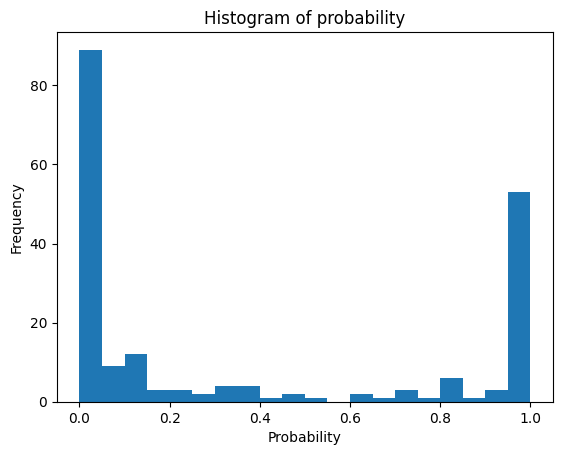

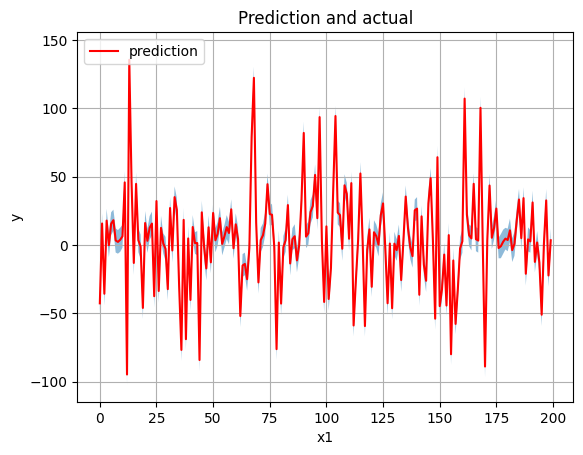

In [7]:
# テストデータに対する予測

model.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(x_test))

# observed_predから平均と分散を取得
mean = observed_pred.mean
variance = observed_pred.variance
std_dev = torch.sqrt(variance)

# scipyの正規分布オブジェクトを作成
norm_dist = stats.norm(loc=mean.detach().numpy(), scale=std_dev.detach().numpy())

# x以下となる確率を計算
probability_less_than_x = norm_dist.cdf(0)


# probability_less_than_x のヒストグラムを作成

plt.hist(probability_less_than_x, bins=20)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Histogram of probability')
plt.show()

# 予測と予測誤差と実測値のプロット

plt.plot(range(200), mean, 'r', label='prediction')
plt.fill_between(range(200), mean - 3.0*std_dev, mean + 3.0*std_dev, alpha=0.5)
plt.legend(loc='upper left')
plt.xlabel('x1')
plt.ylabel('y')
plt.title('Prediction and actual')
plt.grid(True)
plt.show()


In [8]:
# print(std_dev/mean)
print(type(mean))

<class 'torch.Tensor'>
